### Imports

In [1]:
!pip install plotly==5.13.0
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.2/15.2 MB 44.9 MB/s eta 0:00:00
  Attempting uninstall: plotly
    Found existing installation: plotly 5.13.1
    Uninstalling plotly-5.13.1:
      Successfully uninstalled plotly-5.13.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 41.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 74.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 87.4 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy import stats
import seaborn as sns

import plotly.express as px
from urllib.request import urlopen
import folium
from folium import plugins
from folium.plugins import HeatMap

import geopandas as gpd
from shapely.geometry import Point
from geopandas import GeoDataFrame

import requests
import urllib.parse
import json


### Load dataset

In [28]:
from google.colab import drive
drive.mount('/content/drive')

datasets_path = '/content/drive/MyDrive/Colab Notebooks/datasets/socialdata'
# file_path = "Existing_Buildings_Energy_Performance_Ordinance_Report.csv"
file_path = "Existing_Buildings_Energy_Performance_Ordinance_Report_with_latlng.csv" # Preprocessed dataset with latitude and longitude
dataset_path = os.path.join(datasets_path, file_path)
print(dataset_path)

df = pd.read_csv(dataset_path) 

# Optional: set display options to show all columns
pd.set_option('display.max_columns', None)

# Select float format
pd.set_option('float_format', '{:.2f}'.format)

# Set main colors for plots
color='lavender'
edgecolor='indigo'

# Show the first few rows of the resulting dataframe
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/datasets/socialdata/Existing_Buildings_Energy_Performance_Ordinance_Report_with_latlng.csv


,Unnamed: 0,Parcel(s),Building Name,Building Address,Postal Code,Floor Area,Category,Property Type - Self Selected,PIM Link,Year Built,Energy Audit Due Date,Energy Audit Status,2021 ENERGY STAR Score,2021 Site EUI (kBtu/ft2),2021 Source EUI (kBtu/ft2),2021 Percent Better than National Median Site EUI,2021 Weather Normalized Site EUI (kBtu/ft2),2021 Weather Normalized Source EUI (kBtu/ft2),2021 Total GHG Emissions (Metric Tons CO2e),2021 Total GHG Emissions Intensity (kGCO2e/ft2),2021 Electricity Use - Grid Purchase (kWh),2021 Natural Gas Use (kBtu),2021 District Steam Use (kBtu),2021 Site Energy Use (kBtu),2020 ENERGY STAR Score,2020 Site EUI (kBtu/ft2),2020 Source EUI (kBtu/ft2),2020 Percent Better than National Median Site EUI,2020 Weather Normalized Site EUI (kBtu/ft2),2020 Weather Normalized Source EUI (kBtu/ft2),2020 Total GHG Emissions (Metric Tons CO2e),2020 Total GHG Emissions Intensity (kGCO2e/ft2),2020 Electricity Use - Grid Purchase (kWh),2020 Natural Gas Use (kBtu),2020 District Steam Use (kBtu),2020 Site Energy Use (kBtu),2019 ENERGY STAR Score,2019 Site EUI (kBtu/ft2),2019 Source EUI (kBtu/ft2),2019 Percent Better than National Median Site EUI,2019 Weather Normalized Site EUI (kBtu/ft2),2019 Weather Normalized Source EUI (kBtu/ft2),2019 Total GHG Emissions (Metric Tons CO2e),2019 Total GHG Emissions Intensity (kGCO2e/ft2),2019 Electricity Use - Grid Purchase (kWh),2019 Natural Gas Use (kBtu),2019 District Steam Use (kBtu),2019 Site Energy Use (kBtu),2018 ENERGY STAR Score,2018 Site EUI (kBtu/ft2),2018 Source EUI (kBtu/ft2),2018 Percent Better than National Median Site EUI,2018 Weather Normalized Site EUI (kBtu/ft2),2018 Weather Normalized Source EUI (kBtu/ft2),2018 Total GHG Emissions (Metric Tons CO2e),2018 Total GHG Emissions Intensity (kGCO2e/ft2),2018 Electricity Use - Grid Purchase (kWh),2018 Natural Gas Use (kBtu),2018 District Steam Use (kBtu),2018 Site Energy Use (kBtu),2017 ENERGY STAR Score,2017 Site EUI (kBtu/ft2),2017 Source EUI (kBtu/ft2),2017 Percent Better than National Median Site EUI,2017 Weather Normalized Site EUI (kBtu/ft2),2017 Weather Normalized Source EUI (kBtu/ft2),2016 ENERGY STAR Score,2016 Site EUI (kBtu/ft2),2016 Source EUI (kBtu/ft2),2016 Percent Better than National Median Site EUI,2016 Percent Better than National Median Source EUI,2016 Weather Normalized Site EUI (kBtu/ft2),2016 Weather Normalized Source EUI (kBtu/ft2),2015 ENERGY STAR Score,2015 Site EUI (kBtu/ft2),2015 Source EUI (kBtu/ft2),2015 Percent Better than National Median Site EUI,2015 Weather Normalized Site EUI (kBtu/ft2),2015 Weather Normalized Source EUI (kBtu/ft2),2014 ENERGY STAR Score,2014 Site EUI (kBtu/ft2),2014 Source EUI (kBtu/ft2),2014 Percent Better than National Median Site EUI,2014 Weather Normalized Site EUI (kBtu/ft2),2014 Weather Normalized Source EUI (kBtu/ft2),2013 ENERGY STAR Score,2013 Site EUI (kBtu/ft2),2013 Source EUI (kBtu/ft2),2013 Percent Better than National Median Site EUI,2013 Weather Normalized Site EUI (kBtu/ft2),2013 Weather Normalized Source EUI (kBtu/ft2),2012 ENERGY STAR Score,2012 Site EUI (kBtu/ft2),2012 Source EUI (kBtu/ft2),2012 Percent Better than National Median Site EUI,2012 Weather Normalized Site EUI (kBtu/ft2),2012 Weather Normalized Source EUI (kBtu/ft2),2011 ENERGY STAR Score,2011 Site EUI (kBtu/ft2),2011 Source EUI (kBtu/ft2),2011 Percent Better than National Median Site EUI,2011 Weather Normalized Site EUI (kBtu/ft2),2011 Weather Normalized Source EUI (kBtu/ft2),2021 Benchmark Status,2021 Reason for Exemption,2020 Benchmark Status,2020 Reason for Exemption,2019 Benchmark Status,2019 Reason for Exemption,2018 Benchmark Status,2018 Reason for Exemption,2017 Benchmark Status,2017 Reason for Exemption,2016 Benchmark Status,2016 Reason for Exemption,2015 Benchmark Status,2015 Reason for Exemption,2014 Benchmark Status,2014 Reason for Exemption,2013 Benchmark Status,2013 Reason for Exemption,2012 Benchmark Status,2012 Reason for Exemption,2011 Benchmark Status,2011 Reason for 

### Select focus columns

In [29]:
# focus_colums = ['Building Address', 'Postal Code', 'Category', '2021 Total GHG Emissions (Metric Tons CO2e)', '2020 Total GHG Emissions (Metric Tons CO2e)',  '2019 Total GHG Emissions (Metric Tons CO2e)',  '2018 Total GHG Emissions (Metric Tons CO2e)', 'lat', 'lng']
focus_colums = ['Parcel(s)', 'Building Name', 'Building Address', 'Postal Code', 'Floor Area',	
                'Category',	'Property Type - Self Selected', '2021 Total GHG Emissions (Metric Tons CO2e)', '2020 Total GHG Emissions (Metric Tons CO2e)',  '2019 Total GHG Emissions (Metric Tons CO2e)',  '2018 Total GHG Emissions (Metric Tons CO2e)', 'lat', 'lng']

# Select focus columns
df = df[focus_colums]

# Rename columns
columns_to_rename = {
    '2018 Total GHG Emissions (Metric Tons CO2e)': '2018_carbon_emissions',
    '2019 Total GHG Emissions (Metric Tons CO2e)': '2019_carbon_emissions',
    '2020 Total GHG Emissions (Metric Tons CO2e)': '2020_carbon_emissions',
    '2021 Total GHG Emissions (Metric Tons CO2e)': '2021_carbon_emissions'
}

# use the rename() method to rename the columns
df = df.rename(columns=columns_to_rename)

print(df.shape)
# Drop null values
# focus_df = focus_df.dropna()
print(df.shape)
df.head()

(2522, 13)
(2522, 13)


,Parcel(s),Building Name,Building Address,Postal Code,Floor Area,Category,Property Type - Self Selected,2021_carbon_emissions,2020_carbon_emissions,2019_carbon_emissions,2018_carbon_emissions,lat,lng
0,0010/001,2801 Leavenworth Street,2801 LEAVENWORTH ST,94109.0,133675.0,Commercial,Office,347.8,384.6,456.7,499.1,37.806973,-122.419034
1,0010/002,Argonaut Hotel-SV,495 JEFFERSON ST,94109.0,180000.0,Commercial,Hotel,414.3,289.9,NaN,667.4,37.807188,-122.420228
2,0011/007,Anchorage Square (2800 Leavenworth),2800 LEAVENWORTH ST,94133.0,485846.0,Commercial,Strip Mall,443.1,498.5,NaN,NaN,37.806997,-122.418828
3,0011/008,Anchorage Garage,500 BEACH ST,94133.0,198525.0,Commercial,Strip Mall,NaN,NaN,NaN,219.7,37.807130,-122.417931
4,0012/001,211 Jefferson St,2739 TAYLOR ST,94133.0,40052.0,Commercial,Retail Store,53.6,112.6,177.5,151.3,37.807654,-122.415796


### Melt different years in 1 column

In [30]:
# use the melt() function to convert the four columns into a single column
# called 'carbon emissions' and add a new column called 'year'
df = df.melt(
    id_vars = ['Parcel(s)', 'Building Name', 'Building Address', 'Postal Code', 'Floor Area',
           'Category', 'Property Type - Self Selected', 'lat', 'lng'], 
    value_vars=['2018_carbon_emissions', '2019_carbon_emissions', 
                '2020_carbon_emissions', '2021_carbon_emissions'],
    var_name='year', # new column name for the year
    value_name='carbon_emissions' # new column name for the GHG emissions
)

# extract the year from the 'year' column by removing the non-numeric characters
df['year'] = df['year'].str.extract('(\d+)').astype(int)

# print the resulting dataframe
df.head()

,Parcel(s),Building Name,Building Address,Postal Code,Floor Area,Category,Property Type - Self Selected,lat,lng,year,carbon_emissions
0,0010/001,2801 Leavenworth Street,2801 LEAVENWORTH ST,94109.0,133675.0,Commercial,Office,37.806973,-122.419034,2018,499.1
1,0010/002,Argonaut Hotel-SV,495 JEFFERSON ST,94109.0,180000.0,Commercial,Hotel,37.807188,-122.420228,2018,667.4
2,0011/007,Anchorage Square (2800 Leavenworth),2800 LEAVENWORTH ST,94133.0,485846.0,Commercial,Strip Mall,37.806997,-122.418828,2018,NaN
3,0011/008,Anchorage Garage,500 BEACH ST,94133.0,198525.0,Commercial,Strip Mall,37.807130,-122.417931,2018,219.7
4,0012/001,211 Jefferson St,2739 TAYLOR ST,94133.0,40052.0,Commercial,Retail Store,37.807654,-122.415796,2018,151.3


### Add column "Carbon Emission / Floor Area (ratio)	"

In [33]:
df['emission_floor_ratio'] = df['Floor Area']/df['carbon_emissions']
df.head()

,Parcel(s),Building Name,Building Address,Postal Code,Floor Area,Category,Property Type - Self Selected,lat,lng,year,carbon_emissions,emission_floor_ratio
0,0010/001,2801 Leavenworth Street,2801 LEAVENWORTH ST,94109.0,133675.0,Commercial,Office,37.806973,-122.419034,2018,499.1,267.832098
1,0010/002,Argonaut Hotel-SV,495 JEFFERSON ST,94109.0,180000.0,Commercial,Hotel,37.807188,-122.420228,2018,667.4,269.703326
2,0011/007,Anchorage Square (2800 Leavenworth),2800 LEAVENWORTH ST,94133.0,485846.0,Commercial,Strip Mall,37.806997,-122.418828,2018,NaN,NaN
3,0011/008,Anchorage Garage,500 BEACH ST,94133.0,198525.0,Commercial,Strip Mall,37.807130,-122.417931,2018,219.7,903.618571
4,0012/001,211 Jefferson St,2739 TAYLOR ST,94133.0,40052.0,Commercial,Retail Store,37.807654,-122.415796,2018,151.3,264.719101


### Plot heatmap (carbon emissions)

In [34]:
# Create focus_df
focus_df = df[df['year']==2020]

# Define map
map = folium.Map(location=[37.773972, -122.431297],
            tiles = "Stamen Toner",
            zoom_start=13)

# Ensure you're handing it floats
focus_df['lat'] = focus_df['lat'].astype(float)
focus_df['lng'] = focus_df['lng'].astype(float)

# Filter the DF for rows, then columns, then remove NaNs
focus_df = focus_df[['lat', 'lng', 'carbon_emissions']]
focus_df = focus_df.dropna(axis=0, subset=['lat','lng','carbon_emissions'])

# List comprehension to make out list of lists
heat_data = [[row['lat'],row['lng'],row['carbon_emissions']] for index, row in focus_df.iterrows()]

# Plot it on the map
HeatMap(heat_data).add_to(map)

# Show map
map

<ipython-input-34-9677e3cc16d0>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  focus_df['lat'] = focus_df['lat'].astype(float)
<ipython-input-34-9677e3cc16d0>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  focus_df['lng'] = focus_df['lng'].astype(float)


### Scatter plot (carbon emissions)

In [35]:
# Create focus_df
focus_df = df[df['year']==2020]

# Define map
map = folium.Map(location=[37.773972, -122.431297],
            tiles = "Stamen Toner",
            zoom_start=13)

# Ensure you're handing it floats
focus_df['lat'] = focus_df['lat'].astype(float)
focus_df['lng'] = focus_df['lng'].astype(float)

# Filter the DF for rows, then columns, then remove NaNs
focus_df = focus_df[['lat', 'lng', 'carbon_emissions']]
focus_df = focus_df.dropna(axis=0, subset=['lat','lng','carbon_emissions'])

# Create a list of circle markers for each building
for index, row in focus_df.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lng']],
        radius=row['carbon_emissions'] / 1000,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        tooltip=row['carbon_emissions']
    ).add_to(map)

# Show map
map

<ipython-input-35-a7148133abdb>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  focus_df['lat'] = focus_df['lat'].astype(float)
<ipython-input-35-a7148133abdb>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  focus_df['lng'] = focus_df['lng'].astype(float)


### Scatter plot (emission_floor_ratio)


In [39]:
# Create focus_df
focus_df = df[df['year']==2020]

# Define map
map = folium.Map(location=[37.773972, -122.431297],
            tiles = "Stamen Toner",
            zoom_start=13)

# Ensure you're handing it floats
focus_df['lat'] = focus_df['lat'].astype(float)
focus_df['lng'] = focus_df['lng'].astype(float)

# Filter the DF for rows, then columns, then remove NaNs
focus_df = focus_df[['lat', 'lng', 'emission_floor_ratio']]
focus_df = focus_df.dropna(axis=0, subset=['lat','lng','emission_floor_ratio'])

# Create a list of circle markers for each building
for index, row in focus_df.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lng']],
        radius=row['emission_floor_ratio'] / 600,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        tooltip=row['emission_floor_ratio']
    ).add_to(map)

# Show map
map

<ipython-input-39-580fd02305da>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  focus_df['lat'] = focus_df['lat'].astype(float)
<ipython-input-39-580fd02305da>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  focus_df['lng'] = focus_df['lng'].astype(float)


### Select outliers

In [55]:


# Select outliers
focus_df = df[df["emission_floor_ratio"] > 20000]
focus_df = focus_df.sort_values(by='emission_floor_ratio', ascending=False)

focus_df.head(20)

,Parcel(s),Building Name,Building Address,Postal Code,Floor Area,Category,Property Type - Self Selected,lat,lng,year,carbon_emissions,emission_floor_ratio
8166,0309/007,146 GEARY ST,146 GEARY ST,94108.00,12400.00,Commercial,Retail Store,37.79,-122.41,2021,0.00,inf
7700,0136/004A,940 BATTERY ST,940 BATTERY ST,94111.00,28000.00,Commercial,Non-Refrigerated Warehouse,37.80,-122.40,2021,0.10,280000.00
9440,3763/015A,460 BRYANT ST,460 BRYANT ST,94107.00,60000.00,Commercial,Office,37.78,-122.40,2021,0.70,85714.29
8648,0796/004,Banneker Homes,1 BANNEKER WAY,94102.00,128285.00,Mixed Residential,Multifamily Housing,37.78,-122.43,2021,3.30,38874.24
2171,4083/001A,2345 Harrison,2345 HARRISON ST,94110.00,53000.00,Commercial,Other,37.76,-122.41,2018,1.90,27894.74
4693,4083/001A,2345 Harrison,2345 HARRISON ST,94110.00,53000.00,Commercial,Other,37.76,-122.41,2019,2.30,23043.48
9737,4083/001A,2345 Harrison,2345 HARRISON ST,94110.00,53000.00,Commercial,Other,37.76,-122.41,2021,2.40,22083.33


### Plot only the outliers

In [58]:
# Define map
map = folium.Map(location=[37.773972, -122.431297],
            tiles = "Stamen Toner",
            zoom_start=13)

# Ensure you're handing it floats
focus_df['lat'] = focus_df['lat'].astype(float)
focus_df['lng'] = focus_df['lng'].astype(float)

# Filter the DF for rows, then columns, then remove NaNs
focus_df = focus_df[['lat', 'lng', 'Building Address', 'year', 'emission_floor_ratio']]
focus_df = focus_df.dropna(axis=0, subset=['lat','lng','Building Address', 'year', 'emission_floor_ratio'])

# Create a list of circle markers for each building
for index, row in focus_df.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lng']],
        radius=row['emission_floor_ratio'] / 3000,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        tooltip=row['emission_floor_ratio'],
        popup=f"address: {row['Building Address']}<br>emission_ratio: {row['emission_floor_ratio']}<br>year: {row['year']}"  # add the building address and carbon emission value as a label
    ).add_to(map)

# Show map
map

### Heatmap movie (to be fixed)

In [59]:
# Create focus_df
focus_df = df.copy()

# Define map
map = folium.Map(location=[37.773972, -122.431297],
            tiles = "Stamen Toner",
            zoom_start=13)

# Ensure you're handing it floats
focus_df['lat'] = focus_df['lat'].astype(float)
focus_df['lng'] = focus_df['lng'].astype(float)

# Filter the DF for rows, then columns, then remove NaNs
focus_df = focus_df.dropna(axis=0, subset=['lat','lng'])

# Create weight column, using date
focus_df['Weight'] = focus_df['year'] # Uses day as a period for every frame in the movie (1 day == 1 frame)
# Careful, if we wanted to do more than 31 days we should add the month to the weight, otherwise it would group the same days of different months
focus_df['Weight'] = focus_df['Weight'].astype(float)
focus_df = focus_df.dropna(axis=0, subset=['lat','lng', 'Weight'])


# List comprehension to make out list of lists
heat_data = [[[row['lat'],row['lng']] for index, row in focus_df[focus_df['Weight'] == i].iterrows()] for i in range(0,focus_df['Weight'].nunique())] # Range in this case is 31 days

# Plot it on the map
hm = plugins.HeatMapWithTime(heat_data,auto_play=True,max_opacity=0.8)
hm.add_to(map)

# Display the map
map

# ----------------------------------------OTHER CODE----------------------------------------

## Data preprocessing

### Get lat and lon from addresd and postal code

In [ ]:
df.dropna(subset = ['Postal Code'], inplace=True)

# Define a function to get the latitude and longitude for a given address and postal code
def get_lat_lon(address, postal_code):
    url = 'https://nominatim.openstreetmap.org/search/' + urllib.parse.quote(address + ', ' + str(int(postal_code))) + '?format=json'
    response = requests.get(url).json()
    if response == []:
        print(url)
        return None, None
    return response[0]['lat'], response[0]['lon']

# Apply the function to the DataFrame and add the results to new columns
focus_df[['lat', 'lon']] = focus_df.apply(lambda x: get_lat_lon(x['Building Address'], x['Postal Code']), axis=1, result_type='expand')

# Print the resulting DataFrame
focus_df.head()

## Data exploration

### Yearly carbon emission mean

In [ ]:
carbon_emission_mean = []

for i in range(2018, 2022):
    mean = df[str(i) + " Total GHG Emissions (Metric Tons CO2e)"].mean()
    carbon_emission_mean.append(f"Year {i}: {mean:.2f}")
print(carbon_emission_mean)

['Year 2018: 452.21', 'Year 2019: 419.89', 'Year 2020: 395.75', 'Year 2021: 591.50']


### Distribution (Category)


Commercial                    1645
Mixed Residential              677
Multifamily                    187
Commercial - Port Facility      29
Cannabis Business               14
Residential                      7
Name: Category, dtype: int64


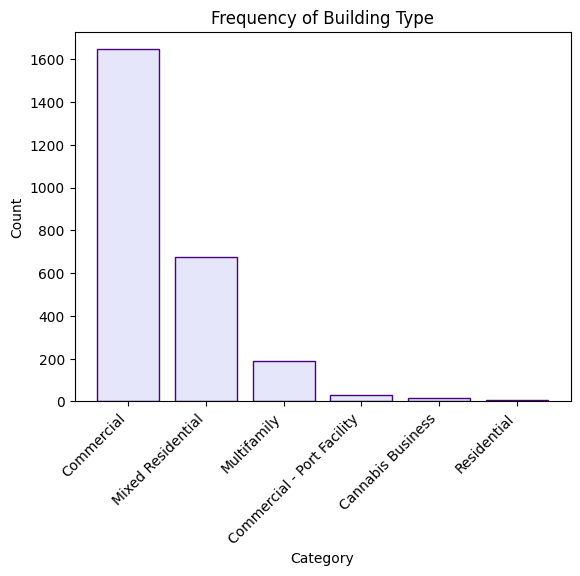

In [ ]:
print(df['Category'].value_counts())
category_frequency = df['Category'].value_counts()

# Bar plot
plt.bar(x=category_frequency.index, height=category_frequency, color=color, edgecolor=edgecolor)

plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Frequency of Building Type')

# Set x tick labels
plt.xticks(rotation=45, ha='right')

plt.show()

### Distribution Histogram (Carbon emissions 2020)

(2559,)
(1550,)
716     1.1
250     1.3
1771    1.5
2211    1.6
2388    1.9
1621    2.3
1864    2.4
691     2.5
643     3.1
1937    3.1
Name: 2020 Total GHG Emissions (Metric Tons CO2e), dtype: float64
684     3762.0
2111    3858.1
1189    4454.4
2065    4758.6
1609    4973.7
1644    5441.9
1639    5754.0
1574    5831.2
370     7561.4
1827    7929.4
Name: 2020 Total GHG Emissions (Metric Tons CO2e), dtype: float64
Num points: 1547


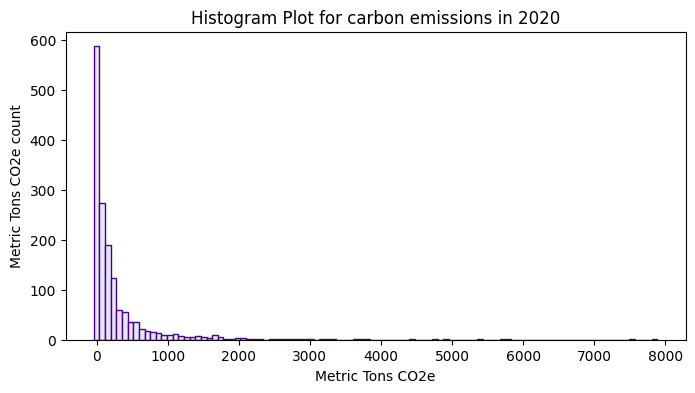

In [ ]:
def plot_histogram(focus_year, n_bins, figsize, discard_higher_than=8000):
    # Create focus dataset
    focus_column = str(focus_year) + " Total GHG Emissions (Metric Tons CO2e)"
    focus_df = df[focus_column] # Filter by year
    print(focus_df.shape)

    # Drop null values
    focus_df = focus_df.dropna()
    print(focus_df.shape)


    # Remove outliers
    focus_df = focus_df.sort_values()
    focus_df = focus_df[focus_df <= discard_higher_than] # Since only 2 values are higher than 8000 we'll discard them
    focus_df = focus_df[focus_df >= 0] # Remove negative values

    print(focus_df.head(10))
    print(focus_df.tail(10))

    # Compute histogram
    bin_counts, bin_edges = np.histogram(focus_df, n_bins)
    print(f'Num points: {focus_df.shape[0]}')

    # Set the figsize
    plt.figure(figsize=figsize)

    # Create bar plot
    plt.bar(bin_edges[:-1], bin_counts, width=np.diff(bin_edges), edgecolor=edgecolor, color=color)

    # Set plot title and labels
    plt.xlabel('Metric Tons CO2e')
    plt.ylabel('Metric Tons CO2e count')
    plt.title(f'Histogram Plot for carbon emissions in {year}')

    # Show plot
    plt.show()


# Set focus variables
year = 2020
n_bins = 100
figsize = (8,4)

# Plot histogram
plot_histogram(year, n_bins, figsize)

(2559,)
(1325,)
569     1.7
2211    1.8
2200    1.9
2314    2.0
1771    2.8
1621    2.9
250     3.5
867     4.4
2388    4.9
643     5.2
Name: 2018 Total GHG Emissions (Metric Tons CO2e), dtype: float64
2049    3850.5
397     3910.6
307     4303.3
302     4368.9
306     4467.9
2014    4904.7
599     5117.0
1590    5971.1
2065    5998.3
1340    6164.6
Name: 2018 Total GHG Emissions (Metric Tons CO2e), dtype: float64
Num points: 1318


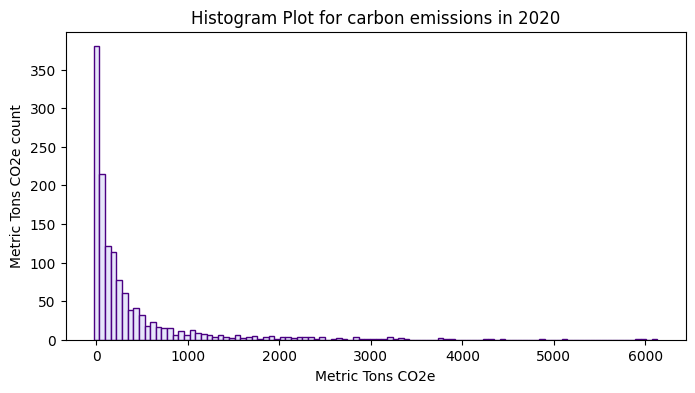

In [ ]:
plot_histogram(2018, n_bins, figsize)